# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.188663,True,5.406654
1,1.849571,True,8.160501
2,-0.156137,False,0.806942
3,2.564780,True,10.857633
4,1.494717,True,8.831416
...,...,...,...
995,0.939251,True,8.791504
996,-1.360316,False,-3.409929
997,-0.526389,False,0.758758
998,1.385032,True,8.087626


<AxesSubplot: xlabel='v0'>

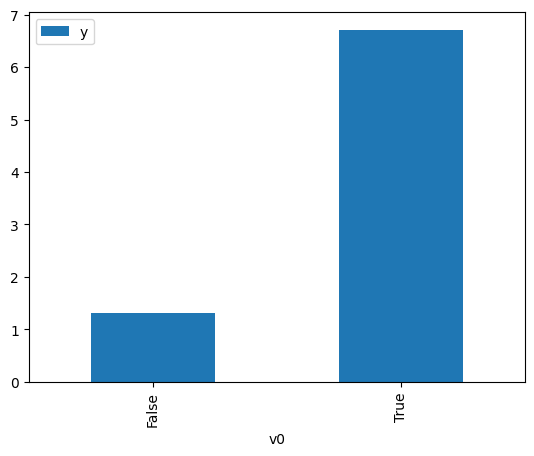

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

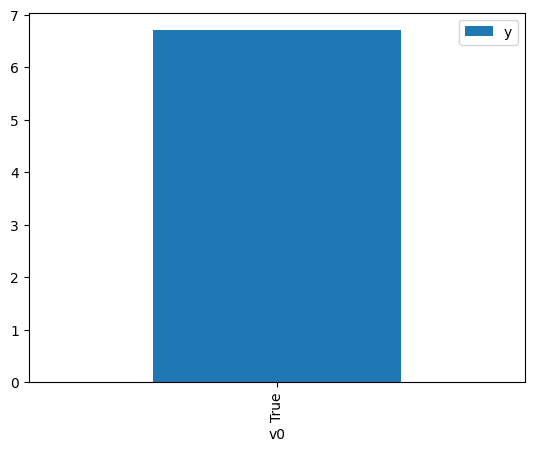

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.300738,False,-0.305711,0.427079,2.341486
1,1.486214,False,0.797213,0.107126,9.334805
2,0.126564,False,0.279352,0.493650,2.025726
3,-0.384421,False,-2.875337,0.681779,1.466750
4,0.071250,False,-1.109683,0.514953,1.941923
...,...,...,...,...,...
995,0.701635,False,1.442162,0.286692,3.488069
996,1.350995,False,1.738981,0.128747,7.767184
997,0.550221,False,0.385544,0.336663,2.970326
998,-0.961033,False,-2.631643,0.838951,1.191965


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.166341,True,3.914107,0.395099,2.531010
1,1.773155,True,7.451736,0.928414,1.077106
2,1.961068,True,10.612263,0.945428,1.057721
3,2.219454,True,9.361756,0.962683,1.038764
4,1.961068,True,10.612263,0.945428,1.057721
...,...,...,...,...,...
995,1.313809,True,7.469890,0.864688,1.156486
996,-1.185568,True,1.384815,0.119579,8.362660
997,1.091052,True,6.682758,0.819290,1.220568
998,1.133130,True,8.622308,0.828692,1.206721


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          1.936e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:51:47   Log-Likelihood:                         -1437.6
No. Observations:                1000   AIC:                                      2879.
Df Residuals:                     998   BIC:                                      2889.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2712      0.038     60.319      0.000       2.197       2.345
x2             5.0301      0.057     87.746      0.000       4.918       5.143
==============================================================================
Omnibus:                        3.098   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                2.990
Skew:                           0.091   Prob(JB):                        0.224
Kurtosis:                       2.804   Cond. No.                         2.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""